In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import drive
drive.mount("drive/")

Mounted at drive/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp "/content/drive/MyDrive/Kaggle API/kaggle.json" ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
# recupérer les données à partir de kaggle
! kaggle datasets download "jayeshrohansingh/emotion-detection-dataset"


 86% 129M/151M [00:03<00:00, 38.1MB/s]
100% 151M/151M [00:03<00:00, 46.1MB/s]


In [ ]:
! unzip "/content/emotion-detection-dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: fer2013/train/Surprise/2582.jpg  
  inflating: fer2013/train/Surprise/2583.jpg  
  inflating: fer2013/train/Surprise/2584.jpg  
  inflating: fer2013/train/Surprise/2585.jpg  
  inflating: fer2013/train/Surprise/2586.jpg  
  inflating: fer2013/train/Surprise/2587.jpg  
  inflating: fer2013/train/Surprise/2588.jpg  
  inflating: fer2013/train/Surprise/2589.jpg  
  inflating: fer2013/train/Surprise/259.jpg  
  inflating: fer2013/train/Surprise/2590.jpg  
  inflating: fer2013/train/Surprise/2591.jpg  
  inflating: fer2013/train/Surprise/2592.jpg  
  inflating: fer2013/train/Surprise/2593.jpg  
  inflating: fer2013/train/Surprise/2594.jpg  
  inflating: fer2013/train/Surprise/2595.jpg  
  inflating: fer2013/train/Surprise/2596.jpg  
  inflating: fer2013/train/Surprise/2597.jpg  
  inflating: fer2013/train/Surprise/2598.jpg  
  inflating: fer2013/train/Surprise/2599.jpg  
  inflating: fer2013/train/Surprise/26.jpg  
  inflating:

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


In [ ]:
# Looking into the directory
data_dir = './fer2013'
print(os.listdir(data_dir))
classes_train = os.listdir(data_dir + "/train")
classes_valid = os.listdir(data_dir + "/validation")
print(f'Train Classes - {classes_train}')
print(f'Validation Classes - {classes_valid}')

['train', 'README', 'fer2013.csv', 'validation', 'fer2013.bib']
Train Classes - ['Angry', 'Neutral', 'Happy', 'Sad', 'Disgust', 'Surprise', 'Fear']
Validation Classes - ['Angry', 'Neutral', 'Happy', 'Sad', 'Disgust', 'Surprise', 'Fear']


In [ ]:
# Data transforms (Gray Scaling & data augmentation)
train_tfms = tt.Compose([tt.Grayscale(num_output_channels=1),
                         tt.RandomHorizontalFlip(),
                         tt.RandomRotation(30),
                         tt.ToTensor()])

valid_tfms = tt.Compose([tt.Grayscale(num_output_channels=1), tt.ToTensor()])

In [ ]:
train_ds = ImageFolder(data_dir + '/train', train_tfms)
valid_ds = ImageFolder(data_dir + '/validation', valid_tfms)

In [ ]:
train_ds[0][0].shape

torch.Size([1, 48, 48])

In [ ]:
batch_size = 200

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([1, 48, 48])


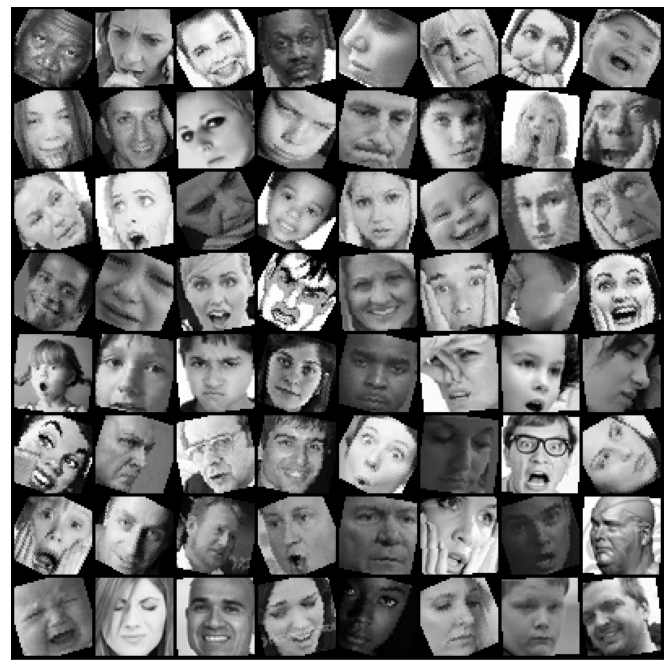

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ELU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet(1, len(classes_train)), device)
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [ ]:
for param in model.parameters():
    print(param.shape)

torch.Size([128, 1, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.

In [ ]:
#@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.11861111223697662, 'val_loss': 1.953256368637085}]

In [ ]:
epochs = 25
max_lr = 0.008
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                        grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.00034, train_loss: 1.9967, val_loss: 1.6877, val_acc: 0.3481
Epoch [1], last_lr: 0.00040, train_loss: 1.6383, val_loss: 1.6158, val_acc: 0.3859
Epoch [2], last_lr: 0.00051, train_loss: 1.5669, val_loss: 1.5848, val_acc: 0.4101
Epoch [3], last_lr: 0.00065, train_loss: 1.4756, val_loss: 1.4977, val_acc: 0.4421
Epoch [4], last_lr: 0.00083, train_loss: 1.4361, val_loss: 1.4643, val_acc: 0.4539
Epoch [5], last_lr: 0.00105, train_loss: 1.4015, val_loss: 1.5368, val_acc: 0.4275
Epoch [6], last_lr: 0.00130, train_loss: 1.3600, val_loss: 1.5730, val_acc: 0.4487
Epoch [7], last_lr: 0.00159, train_loss: 1.3618, val_loss: 1.4898, val_acc: 0.4441
Epoch [8], last_lr: 0.00190, train_loss: 1.3515, val_loss: 1.3875, val_acc: 0.4590
Epoch [9], last_lr: 0.00224, train_loss: 1.4216, val_loss: 1.4151, val_acc: 0.4746
Epoch [10], last_lr: 0.00260, train_loss: 1.3319, val_loss: 1.4472, val_acc: 0.4833
Epoch [11], last_lr: 0.00297, train_loss: 1.3725, val_loss: 1.5942, val_acc: 0.4298
Ep

# Plotting Performance Graphs of the Model

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

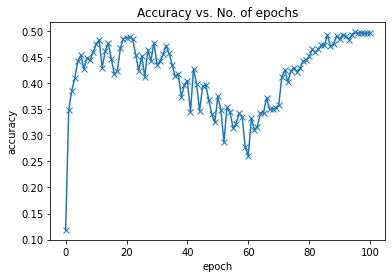

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');


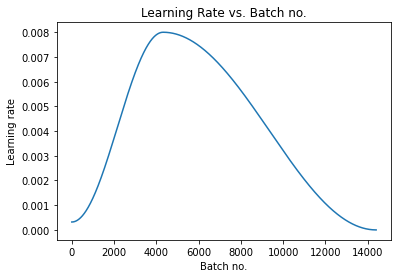

In [ ]:
plot_lrs(history)

In [ ]:
import os
from google.colab import drive
drive.mount("drive/")

Drive already mounted at drive/; to attempt to forcibly remount, call drive.mount("drive/", force_remount=True).


In [ ]:
!ls "/content/drive/MyDrive/HETIC PFA"

Datasets_images  DeepLabv3+_model.png  Raw_Data
deeplab1.png	 Models		       removed_bg_data


In [ ]:
!mkdir models

In [ ]:
torch.save(model.state_dict(), './models/emotion_detection_model_state.pth')

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/HETIC PFA/Models/emotion_detection_model_state.pth')